In [1]:
from ctu_crs import CRS97
import numpy as np
from numpy.typing import NDArray

In [2]:
robot = CRS97(tty_dev=None)

In [3]:
q = np.array([0.0, -0.1, 0.0, 0.0, 0.0, 0.0])

In [4]:
def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector  # Vrátí původní vektor, pokud je norm = 0
    return vector / norm

In [16]:

def make_se3_matrix(circle_pos: NDArray, circle_arm_vector: NDArray, circle_normal_vector: NDArray, tolerance: float=0.001, circle_arm_length: float=0.14):
    #TODO: write docstring 
    #TODO: figure out cirle_arm length
    assert(np.isclose(np.dot(circle_arm_vector, circle_normal_vector), 0.0, atol=tolerance)) #check that the normal and arm vectors are perpendicular
    assert(np.linalg.norm(circle_arm_vector) != 0 and np.linalg.norm(circle_normal_vector) != 0) #directional vectors cannot be 0
    z = normalize(-circle_normal_vector)
    
    x = normalize(circle_arm_vector)
    y = np.cross(x, z) #TODO: this needs to be checked, x and z might need to be switched, depending ot the axis orientations
    rotation_matrix = np.array([x, y, z]).T
    arm_position = circle_pos + x * circle_arm_length #TODO: + or minus?
    
    x_extend = np.append(x, 0.0)
    y_extend = np.append(y, 0.0)
    z_extend = np.append(z, 0.0)
    arm_position_extend = np.append(arm_position, 1.0)
    se3 = np.array([x_extend, y_extend, z_extend, arm_position_extend]).T
    return se3

In [19]:
point = np.array([1, 1, 1])
arm_vector = np.array([2, 1, 0])
normal_vector = np.array([0, 0, 1])
make_se3_matrix(point, arm_vector, normal_vector)

array([[ 0.89442719, -0.4472136 ,  0.        ,  1.12521981],
       [ 0.4472136 ,  0.89442719,  0.        ,  1.0626099 ],
       [ 0.        ,  0.        , -1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
vectr = np.array([1, 0,0])
normalize(vectr)
assert np.linalg.norm(vectr) != 0

In [20]:
c = (0.49899494936611666-0.4) ** 2 + (0.29899494936611665-0.2) ** 2
np.sqrt(c)

np.float64(0.13999999999999999)

Angle decision

In [36]:
import numpy as np


def find_perpendicular_vector(v):
    # v is the vector along which axis rotation happens
    # Find a vector perpendicular to v by crossing v with a non-collinear reference vector
    ref_vector = np.array([1, 0, 0])  # Reference vector
    if np.allclose(v, ref_vector):  # If v is collinear with reference vector
        ref_vector = np.array([0, 1, 0])  # Choose a different reference vector
    return np.cross(v, ref_vector)


def rotate_vector(v, axis, angle):
    # Rotate vector `v` around `axis` by `angle` degrees using Rodrigues' rotation formula
    axis = axis / np.linalg.norm(axis)  # Normalize axis
    angle_rad = np.radians(angle)  # Convert angle to radians
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    return (
            v * cos_theta +
            np.cross(axis, v) * sin_theta +
            axis * np.dot(axis, v) * (1 - cos_theta)
    )

def select_options_around_point(circle_pos: NDArray, circle_normal_vector: NDArray, angle: float=45, n_steps: int=8, first_vector: NDArray=None, tolerance:float=0.001, arm_length:float=0.14):
    # TODO: docstring
    assert(first_vector is None or np.isclose(np.dot(first_vector, circle_normal_vector), 0.0, atol=tolerance))
    
    circle_n = normalize(circle_normal_vector)
    if first_vector is None:
        first_vector = normalize(find_perpendicular_vector(circle_n))
    
    arm_positions = [circle_pos + first_vector * arm_length]
    circle_arm_vectors = [first_vector]
    new_vector = first_vector
    for i in range(1, n_steps):
        new_vector = rotate_vector(new_vector, circle_n, angle)
        arm_positions.append(circle_pos + new_vector * arm_length)
        circle_arm_vectors.append(new_vector)
    
    return arm_positions, circle_arm_vectors



position_c = [2, 2, 2]
normal_c = [1, 1, 1]


points, directions = select_options_around_point(position_c, normal_c, angle=30, n_steps=12, first_vector=None, tolerance=0.001)
for i, point in enumerate(points):
    print(f"ap{i + 1}: {point}")
for i, point in enumerate(directions):
    print(f"Vr{i + 1}: {point}")

ap1: [2.         2.09899495 1.90100505]
ap2: [1.94284524 2.11430952 1.94284524]
ap3: [1.90100505 2.09899495 2.        ]
ap4: [1.88569048 2.05715476 2.05715476]
ap5: [1.90100505 2.         2.09899495]
ap6: [1.94284524 1.94284524 2.11430952]
ap7: [2.         1.90100505 2.09899495]
ap8: [2.05715476 1.88569048 2.05715476]
ap9: [2.09899495 1.90100505 2.        ]
ap10: [2.11430952 1.94284524 1.94284524]
ap11: [2.09899495 2.         1.90100505]
ap12: [2.05715476 2.05715476 1.88569048]
Vr1: [ 0.          0.70710678 -0.70710678]
Vr2: [-0.40824829  0.81649658 -0.40824829]
Vr3: [-7.07106781e-01  7.07106781e-01 -1.13169204e-16]
Vr4: [-0.81649658  0.40824829  0.40824829]
Vr5: [-7.07106781e-01  1.64386552e-16  7.07106781e-01]
Vr6: [-0.40824829 -0.40824829  0.81649658]
Vr7: [-3.41654512e-16 -7.07106781e-01  7.07106781e-01]
Vr8: [ 0.40824829 -0.81649658  0.40824829]
Vr9: [ 7.07106781e-01 -7.07106781e-01  3.28773105e-16]
Vr10: [ 0.81649658 -0.40824829 -0.40824829]
Vr11: [ 7.07106781e-01 -3.88578059e-16

TypeError: unsupported operand type(s) for -: 'list' and 'list'

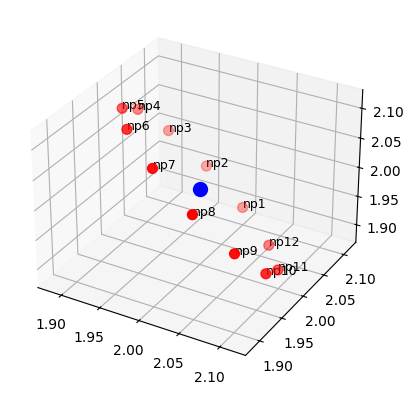

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# visualization


points = np.array(points)  # Convert to NumPy array for easy handling
directions = np.array(directions)

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original point
ax.scatter(position_c[0], position_c[1], position_c[2], color='blue', label='Original Point (p)', s=100)

# Plot the rotated points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red', label='Rotated Points', s=50)

# Annotate points
for i in range(len(points)):
    ax.text(points[i, 0], points[i, 1], points[i, 2], f'np{i + 1}', fontsize=9)

# Plot the rotation axis (vector `v`)
axis_line_start = position_c - 2 * normal_c  # Start point of the axis line
axis_line_end = position_c + 2 * normal_c  # End point of the axis line
ax.plot([axis_line_start[0], axis_line_end[0]],
        [axis_line_start[1], axis_line_end[1]],
        [axis_line_start[2], axis_line_end[2]],
        color='green', label='Rotation Axis')

# Labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Points Rotated Around an Axis')
ax.legend()

# Show the plot
plt.show()

    

In [40]:
# check
for position in points:
    distance = np.linalg.norm(position - position_c)
    # dotproduct = np.dot(position, normal_c)
    print(f"Distance from the center point: {distance}") #, dot product with normal: {dotproduct}")
    
for direction in directions:
    dotproduct = np.dot(direction, normal_c)
    print(f"Dot product with normal: {dotproduct}")

Distance from the center point: 0.13999999999999999
Distance from the center point: 0.1399999999999998
Distance from the center point: 0.13999999999999999
Distance from the center point: 0.14000000000000015
Distance from the center point: 0.13999999999999999
Distance from the center point: 0.13999999999999987
Distance from the center point: 0.13999999999999999
Distance from the center point: 0.14000000000000015
Distance from the center point: 0.13999999999999999
Distance from the center point: 0.13999999999999987
Distance from the center point: 0.13999999999999999
Distance from the center point: 0.14000000000000015
Dot product with normal: 0.0
Dot product with normal: -5.551115123125783e-17
Dot product with normal: -1.1316920370789757e-16
Dot product with normal: -1.1102230246251565e-16
Dot product with normal: -2.220446049250313e-16
Dot product with normal: -1.1102230246251565e-16
Dot product with normal: -1.1102230246251565e-16
Dot product with normal: -5.551115123125783e-17
Dot prod